In [1]:
from pathlib import Path
from object_summary import clf_folders_to_df, objects_in_categories, dump_to_json_file, read_json_from_file
from tf_object_detection_util.inference_api import TFInference

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from object_summary import read_json_from_file
from object_summary.analysis import objects_in_categories_df, get_counts_df
from object_summary.util import tree_viz

import pandas as pd
pd.set_option('display.max_columns', 500)

In [2]:
path = Path('data/messy_vs_clean/sample/')
out_path = Path('out/messy_or_clean/sample/')
out_path.mkdir(exist_ok=True)

def ls(path): return [p for p in path.glob('*')]

"path" variable is the directory containing a list of folders where each folder contains all images of a single category and the name of the folder is the label for the category.

"out_path" is the path where the output visualizations (if visualize=True in "objects_in_categories" method) are stored.

In [3]:
# here, we're using a small subset from Messy vs Clean dataset from Kaggle
# https://www.kaggle.com/cdawn1/messy-vs-clean-room
ls(path)

[PosixPath('data/messy_vs_clean/sample/messy'),
 PosixPath('data/messy_vs_clean/sample/clean')]

We need to pass the path to the ".pb" file (this is the inference graph. the model we use to perform object detection) and the ".pbtxt" file (this provides the mapping from the categorical output of the model (say 0, 1, 2) to the labels of the corresponding objects (say "cat", "dog", "horse")) into the TFInference class. We then need to pass the created TFInference object into the "objects_in_categories" to perform the summarization.

We need to download the pretrained object detection model from tensorflow. Use the below link to download a Faster RCNN model trained on [Open Images](https://opensource.google/projects/open-images-dataset) - 

pb file contained in -  http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12.tar.gz

pbtxt file - https://github.com/tensorflow/models/blob/master/research/object_detection/data/oid_v4_label_map.pbtxt

To select other object detection models, go to the following link - 

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md


In [4]:
def load_faster_rcnn_open_images():
    MODEL_NAME = Path('/home/prasannals/models/research/object_detection/faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12')
    PATH_TO_FROZEN_GRAPH = MODEL_NAME / 'frozen_inference_graph.pb'
    PATH_TO_LABELS = MODEL_NAME / 'oid_v4_label_map.pbtxt'

    inf = TFInference(PATH_TO_FROZEN_GRAPH, PATH_TO_LABELS)
    return inf

In [5]:
# clf_folders_to_df converts the input files into the required format in a DataFrame.
# the output of the "clf_folders_to_df" will be the input to "objects_in_categories" function
path_df = clf_folders_to_df(path)
inf = load_faster_rcnn_open_images()

In [6]:
path

PosixPath('data/messy_vs_clean/sample')

In [7]:
### OPTIONAL - split your "path_df" into several equal DataFrames 
### (useful if you intend to parallely run the code on different machines/GPUs)
from object_summary.util import split_df

split_df(path_df, 2)

[                                                path category
 0  /home/prasannals/object_summary/data/messy_vs_...    messy
 1  /home/prasannals/object_summary/data/messy_vs_...    messy,
                                                 path category
 2  /home/prasannals/object_summary/data/messy_vs_...    clean
 3  /home/prasannals/object_summary/data/messy_vs_...    clean]

In [8]:
path_df

,path,category
0,/home/prasannals/object_summary/data/messy_vs_...,messy
1,/home/prasannals/object_summary/data/messy_vs_...,messy
2,/home/prasannals/object_summary/data/messy_vs_...,clean
3,/home/prasannals/object_summary/data/messy_vs_...,clean


In [9]:
res = objects_in_categories(path_df, inf, out_path, visualize=True)

In [10]:
res

[{'num_detections': 3,
  'detection_boxes': [[0.49435049295425415,
    0.024114329367876053,
    0.9771174192428589,
    0.9858748316764832],
   [0.5543340444564819, 0.5395525693893433, 0.95111483335495, 1.0],
   [0.0, 0.0, 0.9713993668556213, 1.0]],
  'detection_scores': [0.5345741510391235,
   0.4063068926334381,
   0.3590908348560333],
  'detection_classes': [281, 281, 241],
  'detection_classes_translated': ['Table', 'Table', 'House'],
  'img_height': 299,
  'img_width': 299,
  'category': 'messy'},
 {'num_detections': 7,
  'detection_boxes': [[0.7609224319458008,
    0.31506049633026123,
    0.8543164134025574,
    0.5145363211631775],
   [0.7031162977218628,
    0.7674436569213867,
    0.9546673893928528,
    0.9768048524856567],
   [0.397198349237442,
    0.3914088308811188,
    0.7803916931152344,
    0.8724899291992188],
   [0.6339926719665527,
    0.440836101770401,
    0.7189819812774658,
    0.5389726758003235],
   [0.39828160405158997,
    0.36795616149902344,
    0.782823

In [11]:
dump_to_json_file(res, Path('out/messy_or_clean_res_sample.json'))

In [12]:
all_res = read_json_from_file('../object_detection/out/messy_or_clean_res_train.json')

In [13]:
df = objects_in_categories_df(all_res)
df 

,Desk,Building,Table,Window,Office building,category,Shelf,House,Cabinetry,Bed,Clothing,Furniture,Chair,Box,Person,Human face,Toy,Drawer,Bookcase,Pillow,Computer monitor,Food,Tableware,Drink,Balloon,Countertop,Couch,Wheel,Car,Land vehicle,Luggage and bags,Plant,Sofa bed,Loveseat,Studio couch,Tree,Coffee table,Curtain,Window blind,Book,Mobile phone,Houseplant,Pumpkin,Laptop,Man,Washing machine,Flower,Umbrella,Ball,Footwear,Television,Woman,Wine glass,Flowerpot,Bottle,Wine,Kitchen appliance,Microwave oven,Nightstand,Chest of drawers,Waste container,Closet,Bowl,Mixing bowl,Picture frame,Fireplace,Guitar,Stool,Ceiling fan,Mechanical fan,Christmas tree,Kitchen & dining room table,Oven,Home appliance,Wardrobe,Medical equipment,Picnic basket,Computer keyboard
0,2.0,1.0,3.0,1.0,1.0,messy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,messy,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,messy,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,messy,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,messy,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.0,0.0,0.0,0.0,0.0,clean,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,0.0,0.0,0.0,0.0,0.0,clean,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,0.0,0.0,0.0,1.0,0.0,clean,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,0.0,0.0,0.0,0.0,0.0,clean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
clf = DecisionTreeClassifier(random_state=696, max_depth=4)
cat_map = {'messy':0, 'clean':1}
clf.fit(df[set(df.columns) - set(['category'])], df['category'].apply(lambda v: cat_map[v]))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=696, splitter='best')

In [15]:
clf.score(df[set(df.columns) - set(['category'])], df['category'].apply(lambda v: cat_map[v]))

0.828125

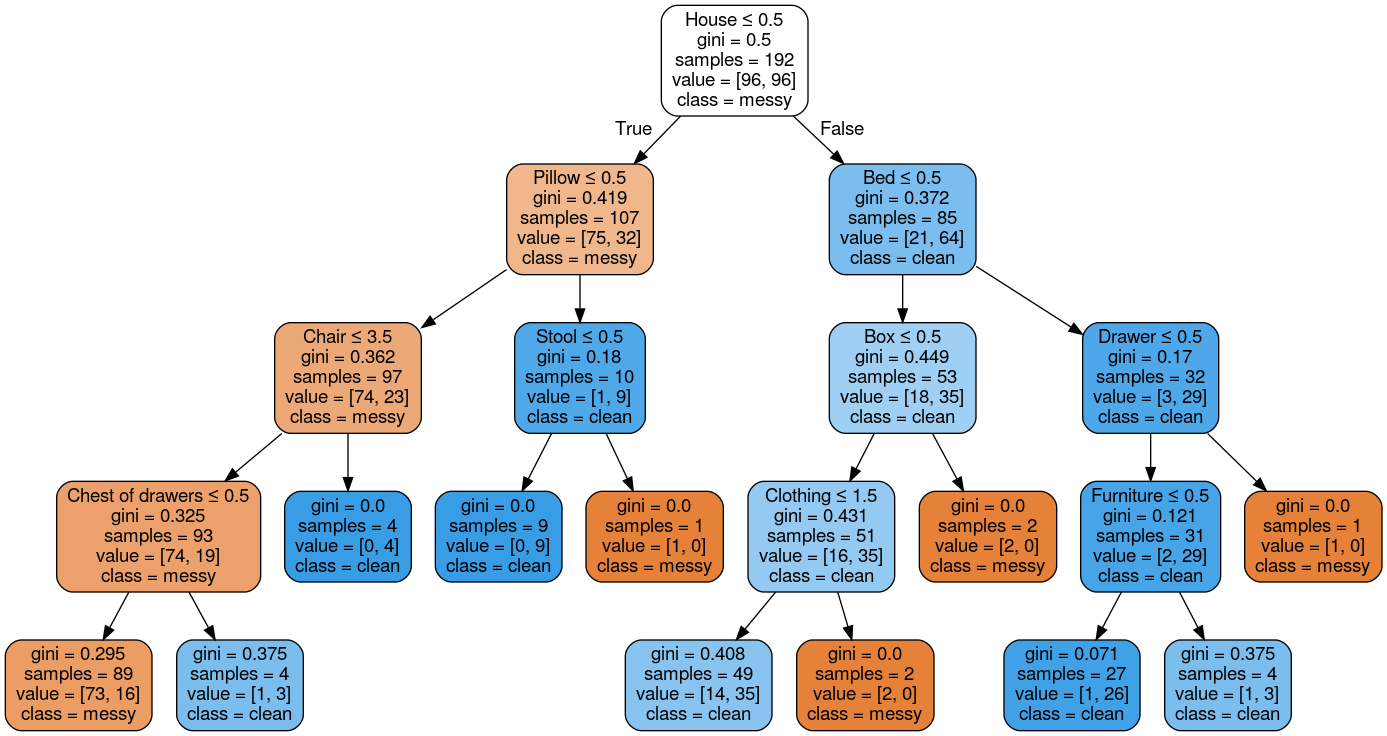

In [16]:
tree_viz(clf, ['messy', 'clean'], list( set(df.columns) - set(['category']) ), 'tree.png')

In [17]:
get_counts_df(all_res)

,Ball,Balloon,Bed,Book,Bookcase,Bottle,Bowl,Box,Building,Cabinetry,Car,Ceiling fan,Chair,Chest of drawers,Christmas tree,Closet,Clothing,Coffee table,Computer keyboard,Computer monitor,Couch,Countertop,Curtain,Desk,Drawer,Drink,Fireplace,Flower,Flowerpot,Food,Footwear,Furniture,Guitar,Home appliance,House,Houseplant,Human face,Kitchen & dining room table,Kitchen appliance,Land vehicle,Laptop,Loveseat,Luggage and bags,Man,Mechanical fan,Medical equipment,Microwave oven,Mixing bowl,Mobile phone,Nightstand,Office building,Oven,Person,Picnic basket,Picture frame,Pillow,Plant,Pumpkin,Shelf,Sofa bed,Stool,Studio couch,Table,Tableware,Television,Toy,Tree,Umbrella,Wardrobe,Washing machine,Waste container,Wheel,Window,Window blind,Wine,Wine glass,Woman
category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
clean,0.0,0.0,60.0,0.0,5.0,0.0,0.0,0.0,7.0,14.0,1.0,2.0,79.0,5.0,1.0,0.0,4.0,10.0,1.0,5.0,28.0,6.0,13.0,15.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,15.0,0.0,1.0,66.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,14.0,4.0,3.0,6.0,1.0,14.0,27.0,2.0,0.0,23.0,8.0,0.0,14.0,52.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,29.0,2.0,0.0,0.0,0.0
messy,1.0,1.0,25.0,1.0,10.0,7.0,2.0,8.0,19.0,7.0,3.0,0.0,34.0,1.0,0.0,1.0,27.0,5.0,0.0,4.0,10.0,4.0,4.0,17.0,1.0,2.0,2.0,1.0,1.0,2.0,3.0,14.0,1.0,0.0,21.0,1.0,5.0,0.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,6.0,0.0,14.0,0.0,1.0,3.0,1.0,1.0,20.0,2.0,1.0,4.0,82.0,1.0,3.0,17.0,1.0,1.0,0.0,3.0,1.0,1.0,11.0,3.0,1.0,2.0,2.0


In [18]:
from tinydb import TinyDB

In [19]:
db = TinyDB('out/messy_or_clean/sample/res_db.json')

In [20]:
db.all()

[{'num_detections': 3,
  'detection_boxes': [[0.49435049295425415,
    0.024114329367876053,
    0.9771174192428589,
    0.9858748316764832],
   [0.5543340444564819, 0.5395525693893433, 0.95111483335495, 1.0],
   [0.0, 0.0, 0.9713993668556213, 1.0]],
  'detection_scores': [0.5345741510391235,
   0.4063068926334381,
   0.3590908348560333],
  'detection_classes': [281, 281, 241],
  'detection_classes_translated': ['Table', 'Table', 'House'],
  'img_height': 299,
  'img_width': 299,
  'category': 'messy'},
 {'num_detections': 7,
  'detection_boxes': [[0.7609224319458008,
    0.31506049633026123,
    0.8543164134025574,
    0.5145363211631775],
   [0.7031162977218628,
    0.7674436569213867,
    0.9546673893928528,
    0.9768048524856567],
   [0.397198349237442,
    0.3914088308811188,
    0.7803916931152344,
    0.8724899291992188],
   [0.6339926719665527,
    0.440836101770401,
    0.7189819812774658,
    0.5389726758003235],
   [0.39828160405158997,
    0.36795616149902344,
    0.782823

In [22]:
df = objects_in_categories_df(db.all())
df 

,Table,House,category,Toy,Box,Coffee table,Studio couch,Couch,Pillow,Clothing,Sofa bed,Countertop,Cabinetry,Oven,Window,Cupboard,Microwave oven
0,2.0,1.0,messy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,messy,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,clean,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,clean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,1.0,1.0,1.0,1.0
